In [1]:
# Importing relevant packages for this notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
import sympy as sm 
sm.init_printing(use_unicode=True)
from scipy.stats import skew
from scipy.stats import kurtosis
from mpl_toolkits.mplot3d import Axes3D
import itertools

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

We start by defining the basic functions of the model, i.e. consumption, utility, disutility and the value of life (the worker's problem)

In [4]:
def c(h,l):
    if l==1:
        return w*h*l # Consumption when working
    elif l==0:
        return b # Consumption when not working

# Utility function
def utility(h,l):
    return (c(h,l)**(1-rho))/(1-rho)

# Disutility when working
def disutility(l):
    return gamma*l

# Consumer's value of life in period 2 dependent on human capital and working status
def v2(h2,l2):
    return utility(h2,l2)-disutility(l2)

# Consumer's value of life in period 1 dependent on human capital and working status
def v1(h1,l1,v2_interp):
    
    # v2 when human capital have low value to the consumer
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # v2 when human capital have high value to the consumer
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # Expected value of life
    exp_v2 = 0.5*v2_low + 0.5*v2_high
    
    # Value of life in period 1
    return utility(h1,l1) - disutility(l1) + beta*exp_v2

Next we depict the value of life in period 2 dependent on human capital the consumer's working status, by plotting the predetermined vector of human capital, h_vec, into the function of the consumer's value of life, v2.

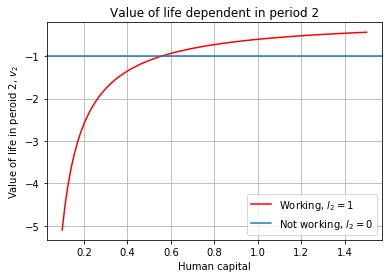

In [5]:
# Plotting value of life in period 2 dependent on human capital.
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,v2(h_vec,1),color="red") # Value of life when working, l2=1
ax.axhline(y=v2(h_vec,0), xmin=0, xmax =1, clip_on = False) # Value of life when not working, l2=0

# Setting grid, labels, etc.
ax.grid()
ax.set_xlabel('Human capital')
ax.set_ylabel('Value of life in peroid 2, $v_2$')
ax.set_title('Value of life dependent in period 2')
plt.legend(('Working, $l_2=1$','Not working, $l_2=0$'),loc='lower right');

Then we solve the model in period 2, and plot labor supply as a function of human capital.

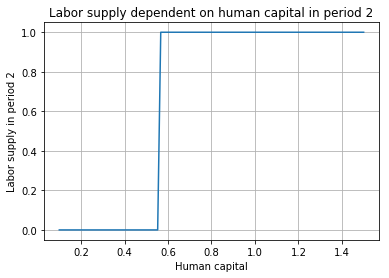

In [6]:
def sol2(h_vec):
    # Creating grids
    v2_vec =  np.empty(100)
    l2_vec = np.empty(100)

    # Solution for h2
    for i, h in enumerate(h_vec):
    
        # Comparing the value of life when working or not, such that the consumer chooses whatever has the higher utility
        if (v2(h,1) > v2(h,0)) == True: # If the consumer gets higher utility from working, then work (l2=1)
            l2_vec[i] = 1
        else: # if the consumer does not get higher utility from working, then do not work (l2=0)
            l2_vec[i] = 0
    
        v2_vec[i] = v2(h,l2_vec[i])
    
    return v2_vec, l2_vec

# Unpacking the solution
v2_vec,l2_vec =  sol2(h_vec)

# Then we plot the solution
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,l2_vec)
ax.grid()
ax.set_xlabel('Human capital')
ax.set_ylabel('Labor supply in period 2')
ax.set_title('Labor supply dependent on human capital in period 2');

We find the level of human capital required for the consumer to work by sympy (whoch is also indicated by the intercept of working/not working in the first figre and by the change labor supply in the second figure.

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

In [7]:
h2=sm.symbols('h_2')
intercept = sm.Eq(1**(1-2)/(1-2),(h2*2*1)**(1-2)/(1-2)-0.1*1)
solution_h2 = sm.solve(intercept,h2)
print(f' When human capital is above ',solution_h2,f' the consumer chooses to work')

 When human capital is above  [0.555555555555556]  the consumer chooses to work


As we have already defined the basic functions, we start by finding the solution to the consumer's problem, i.e. at what leve of human capital she prefers to work, such that she obtains the optimal value of life is.

In [8]:
# Constructing the interpolator
v2_interp = interpolate.RegularGridInterpolator((h_vec,),v2_vec,bounds_error=False,fill_value=None)

# Finding solution
def sol1(h_vec, v2_interp):
    
    # Creating grids
    v1_vec =  np.empty(100)
    l1_vec = np.empty(100)
    
    # Next we solve for each h1 in grid
    for i,h1 in enumerate(h_vec):
        if (v1(h1,1,v2_interp) > v1(h1,0,v2_interp)) == True: # If the consumer gets higher utility from working, then work (l2=1)
            l1_vec[i] = 1
        else: # if the consumer does not get higher utility from working, then do not work (l2=0)
            l1_vec[i] = 0
    
        v1_vec[i] = v1(h1,l1_vec[i],v2_interp)
    
    return v1_vec, l1_vec

In [9]:
# Unpacking the solution
v1_vec, l1_vec =  sol1(h_vec, v2_interp)

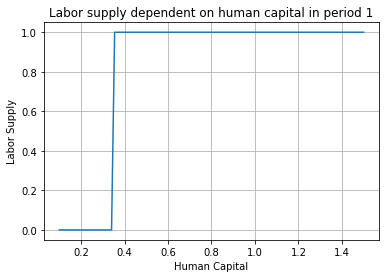

In [10]:
# Then we plot the solution
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,l1_vec)
ax.grid()
ax.set_xlabel('Human Capital')
ax.set_ylabel('Labor Supply')
ax.set_title('Labor supply dependent on human capital in period 1');

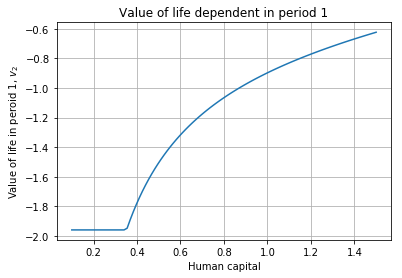

In [11]:
# Plotting value of life in period 1 dependent on human capital.
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,v1_vec) # Plotting optimal value of life
ax.grid()
ax.set_xlabel('Human capital')
ax.set_ylabel('Value of life in peroid 1, $v_2$')
ax.set_title('Value of life dependent in period 1');

Thus we note that the required level of human capital is lower in period 1 than in period 2 for the consumer to work. This is caused by the accumulation of human capital, which implies that working in period 1 has an additional positive effect on the consumers value of life in period 2, hence the consumer is more likely to work.

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

From the result of Q1 and Q2, we note that a higher level of human capital is required for the consumer to work in period 2 than in period 1. Thus, if she never works in period 1 when potential wage income is lower than the unemployment benefits, nor would she ever work under the same conditions in period 2. Herefor we consider only period 1.

We consider a case when her pay is marginal lower than her benefit, i.e. $w_l=0.99$ and benefit is the same as before; $b=1$.

In [12]:
w_l = 0.99

# Redefining the consumption constraint
def c_l(h,l):
    if l==1:
        return w_l*h*l # Consumption when working
    elif l==0:
        return b # Consumption when not working

# Utility function
def utility_l(h,l):
    return (c_l(h,l)**(1-rho))/(1-rho)

# Disutility when working
def disutility(l):
    return gamma*l

# Consumer's value of life in period 2 dependent on human capital and working status
def v2(h2,l2):
    return utility_l(h2,l2)-disutility(l2)
                                                                                 
                                                                                 
def v1_l(h1,l1,v2_interp):
    
    # v2 when human capital has low value to the consumer
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # v2 when human capital has high value to the consumer
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # Expected value of life
    exp_v2 = 0.5*v2_low + 0.5*v2_high
    
    # Value of life in period 1
    return utility_l(h1,l1) - disutility(l1) + beta*exp_v2                                                                                 
                                                                                 
def sol1_l(h_vec, v2_interp):
    
    # Creating grids
    v1_vec =  np.empty(100)
    l1l_vec = np.empty(100)
    
    # Next we solve for each h1 in grid
    for i,h1 in enumerate(h_vec):
        if (v1_l(h1,1,v2_interp) > v1_l(h1,0,v2_interp)) == True: # If the consumer gets higher utility from working, then work (l2=1)
            l1l_vec[i] = 1
        else: # if the consumer does not get higher utility from working, then do not work (l2=0)
            l1l_vec[i] = 0
    
        v1_vec[i] = v1(h1,l1l_vec[i],v2_interp)
    
    return v1_vec, l1l_vec

v1_vec, l1l_vec = sol1_l(h_vec, v2_interp)

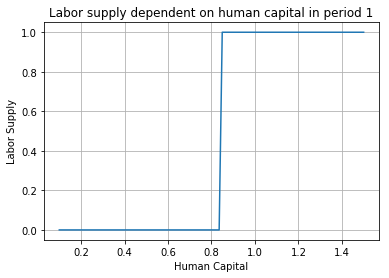

In [13]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec,l1l_vec)
ax.grid()
ax.set_xlabel('Human Capital')
ax.set_ylabel('Labor Supply')
ax.set_title('Labor supply dependent on human capital in period 1');

Thus when human capital is above 0.85, the consumer wants to work in period 1, even though her wage is lower than the benefits, $(w=0.99<b=1)$. The answer to the question is therefore no, the worker will work even though her potential wage is lower than the unemployment benefits. This follows as the value of human capital she receives from working accumulates and hereby the value of life increases more from working than not, even though the wage itself is lower than the benefits.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [14]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

In [15]:
# Defining the variables and the parameters of the model in terms of sympy
y = sm.symbols('y_t')
pi = sm.symbols('pi_t')
y1 = sm.symbols('y_t-1')
pi1 = sm.symbols('pi_t-1')
v = sm.symbols('v_t')
s = sm.symbols('s_t')
s1 = sm.symbols('s_t-1')
gamma = sm.symbols('gamma')
alpha = sm.symbols('alpha')
h = sm.symbols('h')
b = sm.symbols('b')
phi = sm.symbols('phi')

# Defining the AD and SRAS equations in terms of the sympy variables
SRAS = pi1 + gamma*y-phi*gamma*y1+s-phi*s1
AD = 1/(h*alpha)*(v-(1+b*alpha)*y)

In [16]:
# We set SRAS equal to AS 
SRAS_AD = sm.Eq(SRAS, AD)

In [17]:
y_st = sm.solve(SRAS_AD, y)

The optimal value for y in equilibrium is:


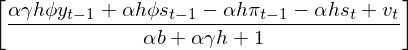

In [18]:
print(f'The optimal value for y in equilibrium is:')
y_st

We can now find the value for $\pi_t$ given the value for $y_t$

In [19]:
pi_st = 1/(h*alpha)*(v-(1+b*alpha)*y_st[0])  # we add [0] as y_t is a list with one element at index 0

The optimal value for pi in equilibrium is:


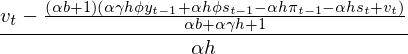

In [20]:
print(f'The optimal value for pi in equilibrium is:')
pi_st

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

Firstly we turn our sympy functions into numerically functions such that we can solve for $y_t$ and $\pi_t$

In [21]:
y_num = sm.lambdify((v,alpha,b,gamma,h,phi,y1,pi1,s,s1),y_st[0])
pi_num = sm.lambdify((v,alpha,b,gamma,h,phi,y1,pi1,s,s1), pi_st)

Next, we define output and inflation as functions, $y_t$ and $\pi_t$

In [22]:
def y_func(v,y1,pi1,s,s1):
    return y_num(v,par['alpha'],par['b'],par['gamma'],par['h'],par['phi'],y1,pi1,s,s1)

def pi_func(v,y1,pi1,s,s1):
    return pi_num(v,par['alpha'],par['b'],par['gamma'],par['h'],par['phi'],y1,pi1,s,s1)

For $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$ we get that $y_t$ and $\pi_t$ in equilibrium are: 

In [23]:
print(f'y in equilibrium:',y_func(v=0,y1=0,pi1=0,s=0,s1=0))
print(f'pi in equilibrium:',pi_func(v=0,y1=0,pi1=0,s=0,s1=0))

y in equilibrium: 0.0
pi in equilibrium: 0.0


For the demand shock $v_t=0.1$ we get that $y_t$ and $\pi_t$ are:

In [24]:
print(f'y when v_t=0.1:',y_func(v=0.1,y1=0,pi1=0,s=0,s1=0))
print(f'pi when v_t=0.1:',pi_func(v=0.1,y1=0,pi1=0,s=0,s1=0))

y when v_t=0.1: 0.0244140625
pi when v_t=0.1: 0.001831054687500002


To illustrate this graphically we define our AD and SRAS curves numerically 

In [25]:
def SRAS_fun(pi1,s,s1,y): 
    return pi1 + par['gamma']*y-par['phi']*par['gamma']*y1+s-par['phi']*s1

def AD_fun(v,y):
    return 1/(par['h']*par['alpha'])*(v-(1+par['b']*par['alpha'])*y)

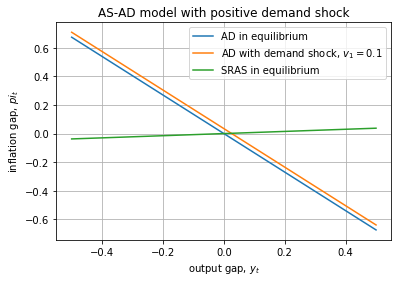

In [26]:
# Plotting the AD and SRAS curve before and after the shock
pi1 = 0 
s = 0 
s1 = 0 
v = 0 
v_shock = 0.1
y = np.linspace(-0.5,0.5,100)

AD_new = AD_fun(v,y)
AD_shock = AD_fun(v_shock,y)
SRAS_new = SRAS_fun(pi1,s,s1,y)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(y, AD_new, label='AD in equilibrium')
ax.plot(y, AD_shock, label='AD with demand shock, $v_1=0.1$')
ax.plot(y, SRAS_new, label='SRAS in equilibrium')
ax.set_xlabel('output gap, $y_t$')
ax.set_ylabel('inflation gap, $pi_t$')
ax.set_title ('AS-AD model with positive demand shock')
ax.grid()
ax.legend();

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [27]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

In [28]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

To examine the evolution of the economy after a persistent shock, $x_0=0.1$, we consider output gap and inflation gap within 100 periods.

In [29]:
# Defining the autoregressive shocks by functions
def v_ar(v1,x):
    return par['delta']*v1+x

def s_ar(s1,c):
    return par['omega']*s1+c

# Setting initial values
T = 100
pi_vec = [0]
y_vec = [0]
s_vec = [0]
v_vec = [0]
c_vec = np.zeros(T)
x_vec = np.zeros(T)
x_vec[1] = 0.1

# Simulation
for t in range(1,T):
    s_vec.append(s_ar(s_vec[t-1],c_vec[t])) # appending the ar-process to the s-vector
    v_vec.append(v_ar(v_vec[t-1],x_vec[t])) # appending the ar-process to the v-vector

    y_vec.append(y_func(v_vec[t],y_vec[t-1],pi_vec[t-1],s_vec[t],s_vec[t-1])) # appending all vectors to output 
    pi_vec.append(pi_func(v_vec[t],y_vec[t-1],pi_vec[t-1],s_vec[t],s_vec[t-1])) # appending all vectors to inflation

C:\Users\Rasmus\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


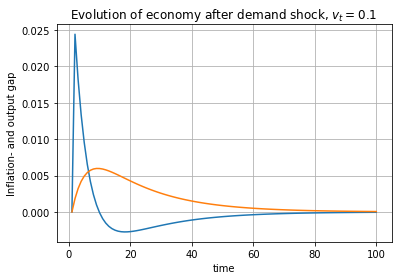

In [30]:
# Creating an empty time-vector, to be able to plot the figure:
time = np.linspace(1,T,T)

# Plotting the result
fig = plt.figure()
plt.axes()
ax = fig.add_subplot(1,1,1)
ax.plot(time, y_vec)
ax.plot(time, pi_vec)
ax.set_xlabel('time')
ax.set_ylabel('Inflation- and output gap')
ax.set_title('Evolution of economy after demand shock, $v_t=0.1$')
ax.grid()

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

In [31]:
# To simulate the shocks we set a seed value, such that we get the same values everytime we run the code
np.random.seed(2608)

# Redefining time and initial values
T_stoc = 1000
pi_stoc_vec = [0]
y_stoc_vec = [0]
s_stoc_vec = [0]
v_stoc_vec = [0]
c_stoc_vec = np.random.normal(loc=0.0,scale=par['sigma_c'],size=1000)
x_stoc_vec = np.random.normal(loc=0.0,scale=par['sigma_x'],size=1000)

# Simulating the stochastic by appending these to shock variables, s and v, and then appending these to output and inflation gap
for t in range(1,T_stoc):
    s_stoc_vec.append(s_ar(s_stoc_vec[t-1],c_stoc_vec[t])) # appending the ar-process to the s-vector
    v_stoc_vec.append(v_ar(v_stoc_vec[t-1],x_stoc_vec[t])) # appending the ar-process to the v-vector

    y_stoc_vec.append(y_func(v_stoc_vec[t],y_stoc_vec[t-1],pi_stoc_vec[t-1],s_stoc_vec[t],s_stoc_vec[t-1])) # appending all vectors to output 
    pi_stoc_vec.append(pi_func(v_stoc_vec[t],y_stoc_vec[t-1],pi_stoc_vec[t-1],s_stoc_vec[t],s_stoc_vec[t-1])) # appending all vectors to inflation

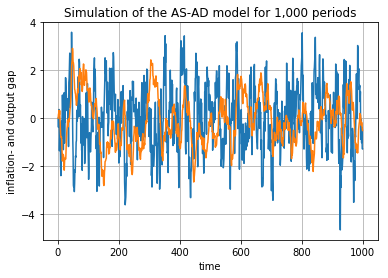

In [32]:
# Creating an empty time-vector, to be able to plot the figure:
time2 = np.linspace(1,T_stoc,T_stoc)

# Plotting the result
fig = plt.figure()
plt.axes()
ax = fig.add_subplot(1,1,1)
ax.plot(time2, y_stoc_vec)
ax.plot(time2, pi_stoc_vec)
ax.set_xlabel('time')
ax.set_ylabel('inflation- and output gap')
ax.set_title('Simulation of the AS-AD model for 1,000 periods')
ax.grid()

In [33]:
# Calculationg statistics using numpy
var_y = np.var(y_stoc_vec)
var_pi = np.var(pi_stoc_vec)
ac_pi = np.corrcoef(pi_stoc_vec[1:T_stoc],pi_stoc_vec[0:-1])
ac_y = np.corrcoef(y_stoc_vec[1:],y_stoc_vec[:-1])
corr_ypi = np.corrcoef(y_stoc_vec,pi_stoc_vec)

# Printing the result
print(f'var(y_t) = {var_y:.3f}')
print(f'var(pi_t) = {var_pi:.3f}')
# For the correlation function, numpy return a matrix of correlations of  y_t with y_t, y_t with y_t-1 etc. Hence we refer to the first number in the first line to find the correlation between the numbers 
print(f'ac(y_t) = {ac_y[0,1]:.3f}')
print(f'ac(pi_t) = {ac_pi[0,1]:.3f}')
print(f'corr(y_t,pi_t) = {corr_ypi[0,1]:.3f}')

var(y_t) = 1.833
var(pi_t) = 1.036
ac(y_t) = 0.757
ac(pi_t) = 0.975
corr(y_t,pi_t) = -0.156


**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

In [34]:
# Setting seed
def correlation_phi(phi):
    np.random.seed(2608)

In [35]:
# First we plot the correlation between inflation and output gap against the level of phi.

# Redefining functions for output and inflaiton gap in terms of phi as a variable
def y_phi_func(phi,v,y1,pi1,s,s1):
    return y_num(v,par['alpha'],par['b'],par['gamma'],par['h'],phi,y1,pi1,s,s1)

def pi_phi_func(phi,v,y1,pi1,s,s1):
    return pi_num(v,par['alpha'],par['b'],par['gamma'],par['h'],phi,y1,pi1,s,s1)

# Defining initial values for the vectors needed in the simulation
def corr_1(phi):
    
    # Redefining initial values
    T_phi = 1000
    v_phi_vec = [0]
    s_phi_vec = [0]
    c_phi_vec = np.random.normal(loc=0.0,scale=par['sigma_c'],size=1000)
    x_phi_vec = np.random.normal(loc=0.0,scale=par['sigma_x'],size=1000)
    pi_phi_vec = [0]
    y_phi_vec = [0]
    corr_vec = [0]
    
    for t in range(1,T_stoc):
        s_phi_vec.append(s_ar(s_phi_vec[t-1],c_phi_vec[t])) # appending the ar-process to the s-vector
        v_phi_vec.append(v_ar(v_phi_vec[t-1],x_phi_vec[t])) # appending the ar-process to the v-vector

        y_phi_vec.append(y_phi_func(phi,v_phi_vec[t],y_phi_vec[t-1],pi_phi_vec[t-1],s_phi_vec[t],s_phi_vec[t-1])) # appending all vectors to output 
        pi_phi_vec.append(pi_phi_func(phi,v_phi_vec[t],y_phi_vec[t-1],pi_phi_vec[t-1],s_phi_vec[t],s_phi_vec[t-1])) # appending all vectors to inflation
    
    corr_phi = np.corrcoef(y_phi_vec,pi_phi_vec)
    
    result=corr_phi[1,0] # refering to the left corner solution of the 2x2 matrix
    
    return result

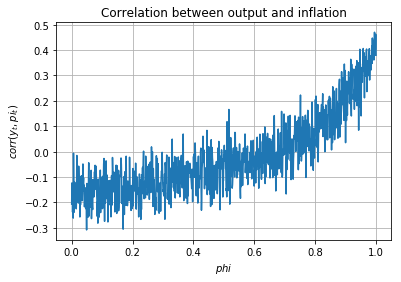

In [36]:
# Creating en empty list for appending the solution
corr_empty =[]

# Creating phi as a vector
phi_vec1 = np.linspace(1e-8,1,1000)

# Looping the solution of the correlation between y and pi over the phi vector
for i in phi_vec1:
    corr_empty.append(corr_1(phi=i))

plt.plot(phi_vec1,corr_empty)
plt.title('Correlation between output and inflation')
plt.xlabel('$phi$');
plt.ylabel('$corr(y_t,pi_t)$');
plt.grid();

In [38]:
# We find the optimal level of phi such that the simulated correlation between y and pi is 0.31 by a root optimizer

# Firstly we define the functions which needs to be zer for the condition to hold
def optimal_phi(phi):
    correlation =  corr_1(phi)
    return correlation -0.31

# Next we find the result by root optimization
result = optimize.root_scalar(optimal_phi,bracket=[0,1],method='brentq')
result

      converged: True
           flag: 'converged'
 function_calls: 33
     iterations: 32
           root: 0.9707419592745496

By this we find that $\phi$ need to be $0.975$ for the correlation between $y_t$ and $\pi_t$ to be $0.31$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [44]:
# a. parameters
N = 50000
mu = np.array([1.5, 2, 1]) 
sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# Preferences for the three goods
alphas = np.exp(np.random.multivariate_normal(mu, sigma, size=N)) 
betas  = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# Exponentially distributed endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

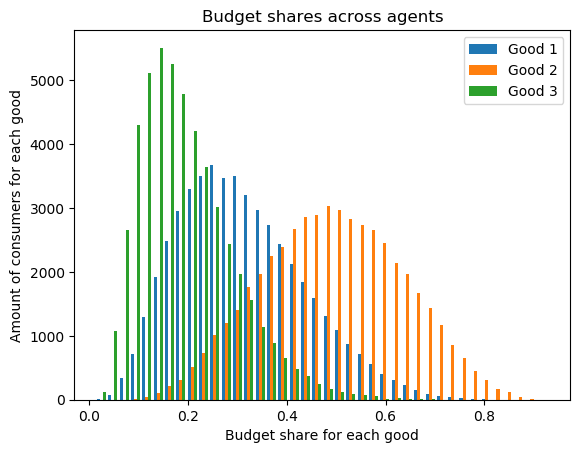

In [45]:
# We create three histograms in a figure to visualize budget shares
plt.style.use('default')
plt.hist(betas, bins = 40, label = ['Good 1', 'Good 2', 'Good 3'])
plt.title('Budget shares across agents')
plt.xlabel('Budget share for each good')
plt.ylabel('Amount of consumers for each good')
plt.legend()

In [46]:
# Parameters
N = 50000
mu = np.array([3, 2, 1]) # Change in the wegihts of mu
sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])

# Seed
seed = 1986
np.random.seed(seed)

# Preferences for the three goods
alphas = np.exp(np.random.multivariate_normal(mu, sigma, size=N))
betas  = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# Exponentially distributed endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

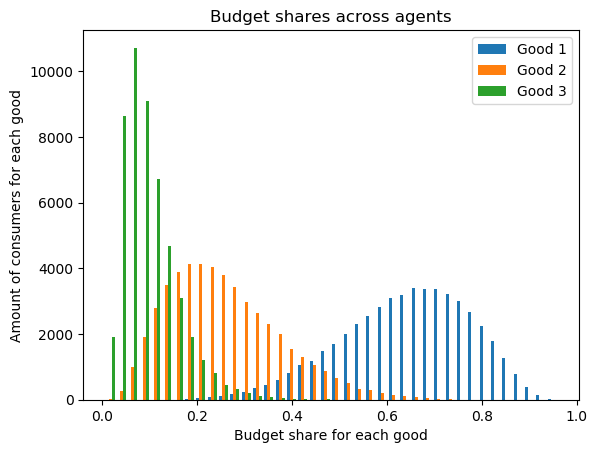

In [47]:
# We create three histograms in a figure to visualize budget shares
plt.style.use('default')
plt.hist(betas, bins = 40, label = ['Good 1', 'Good 2', 'Good 3'])
plt.title('Budget shares across agents')
plt.xlabel('Budget share for each good')
plt.ylabel('Amount of consumers for each good')
plt.legend()

We notice that the budget share across agents depends on the $\mu$-vector due to its role in determining the consumer's valuation of each good. Good 3 has the lowest value for consumers for the given $\mu$-vectors and therefore the lowest budget shares in both figures above.

**Question 2:** Plot the excess demand functions.

To plot the excess demand functions we first determine demand for each good. We then use this function to determine the demand in excess of the supply given by the endowments.

In [48]:
# Defining the demand functions for each good
def good1_func(betas, p1, p2, e1, e2, e3):
    I = p1*e1 + p2*e2 + e3
    return betas[:,0]*I/p1

def good2_func(betas, p1, p2, e1, e2, e3):
    I = p1*e1 + p2*e2 + e3
    return betas[:,1]*I/p2

def good3_func(betas, p1, p2, e1, e2, e3):
    I = p1*e1 + p2*e2 + e3
    return betas[:,2]*I

# Defining the excess demand function for good 1
def excess1_func(betas, p1, p2, e1, e2, e3):
    
    # demand
    demand_1 = np.sum(good1_func(betas, p1, p2, e1, e2, e3))
    
    # supply
    supply_1 = np.sum(e1)
    
    # excess demand
    excess_demand_1 = demand_1 - supply_1
    
    return excess_demand_1

# Defining the excess demand function for good 2
def excess2_func(betas, p1, p2, e1, e2, e3):
    
    # demand
    demand_2 = np.sum(good2_func(betas, p1, p2, e1, e2, e3))
    
    # supply
    supply_2 = np.sum(e2)
    
    # excess demand
    excess_demand_2 = demand_2 - supply_2
    
    return excess_demand_2

# Defining the excess demand function for good 3
def excess3_func(betas, p1, p2, e1, e2, e3):
    
    # demand
    demand_3 = np.sum(demand_good_3_func(betas, p1, p2, e1, e2, e3))
    
    # supply
    supply_3 = np.sum(e3)
    
    # excess demand
    excess_demand_3 = demand_3 - supply_3
    
    return excess_demand_3

In [49]:
size = 50

# We create an empty vector
linspace_p1 = np.linspace(1, 10, size)
linspace_p2 = np.linspace(1, 10, size)

grid1_empty = np.empty((size,size))
grid2_empty = np.empty((size,size))

# Creating excess demand datapoints for all the various combinations of p1 and p2 
p1_grid, p2_grid = np.meshgrid(linspace_p1, linspace_p2) 
for i, p1 in enumerate(linspace_p1):
    for j, p2 in enumerate(linspace_p2):
        grid1_empty[i,j] = excess1_func(betas, p1 , p2, e1, e2, e3)
        grid2_empty[i,j] = excess2_func(betas, p1 , p2, e1, e2, e3)

Text(0.5, 0, '$p_2$')

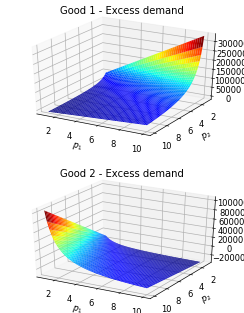

In [50]:
# We create a space for our figures
fig = plt.figure(dpi=60, figsize=(5,10))

# Excess demand of good 1 plotted in 3D
axis1 = fig.add_subplot(3,1,1, projection = '3d')
fig1 = axis1.plot_surface(p1_grid, p2_grid, grid1_empty, cmap=plt.cm.jet, cstride=1, rstride=1)


# Visuals for demand 1
axis1.invert_yaxis()
axis1.set_title('Good 1 - Excess demand')
axis1.set_xlabel('$p_1$')
axis1.set_ylabel('$p_2$')


#Excess demand of good 2 plotted in 3D
axis2 = fig.add_subplot(3,1,2, projection = '3d')
fig2 = axis2.plot_surface(p1_grid, p2_grid, grid2_empty, cmap=plt.cm.jet, cstride=1, rstride=1)

# Visuals for demand 2
axis2.invert_yaxis()
axis2.set_title('Good 2 - Excess demand')
axis2.set_xlabel('$p_1$')
axis2.set_ylabel('$p_2$')

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

The Walras-equilibrium is found by a trial-and-error process. Our solution is the price points for goods 1 and 2 when no demand for good 3 is present. <br/> 
We initially set the pricepoints to $p_1=2$ and $p_2=2$ and set our tolerance is set at $\frac{1}{1.000.000}$. We set t equal to 1 and let it move towards the cap at $25.000$ such that the iteration reaches its goal.

In [51]:
# Set parameters and initial prices
epsilon = 0.000001
kappa = 0.05
p1 = 2
p2 = 2

t=1
cap = 25000

# We minimize the values of our excess_func's from 3.2 until the excess demand is less than the threshold value epsilon
while t < cap:
    ex0_1 = excess1_func(betas, p1, p2, e1, e2, e3)
    ex0_2 = excess2_func(betas, p1, p2, e1, e2, e3)
    
    # If both values of ex0_1 are below the threshold value epsilon, break the loop
    if ex0_1 < epsilon and ex0_2 < epsilon:
        print(f'\nBy iterating {t} times, we find that the price of good 1 and 2 in Walras Equilibrium are: p1 = {p1: .3f} and p2 = {p2: .3f} when there exists no excess demand for good 3.')
        p1target = p1
        p2target = p2
        break
    
    # Price developments according to the specified process in the description
    else:
        p1 += kappa*ex0_1/N
        p2 += kappa*ex0_2/N
    
    # Choice of which iterations to print
    if (t%5 == 0 and t<=50) or t%2500 == 0 or t == 500 or t == 23432 or t == 23433:
        print(f'Iteration {t} -> ex0_1:{ex0_1:5.4f} - ex0_2: {ex0_2:5.4f} -> p1: {p1:5.4f} - p2: {p2:5.4f}')
    
    # Let t move forward
    t += 1

Iteration 5 -> ex0_1:26560.5053 - ex0_2: -16068.6980 -> p1: 2.1416 - p2: 1.9161
Iteration 10 -> ex0_1:22982.3689 - ex0_2: -14337.7508 -> p1: 2.2633 - p2: 1.8409
Iteration 15 -> ex0_1:20159.1957 - ex0_2: -12690.4051 -> p1: 2.3695 - p2: 1.7742
Iteration 20 -> ex0_1:17879.4868 - ex0_2: -11129.9029 -> p1: 2.4633 - p2: 1.7155
Iteration 25 -> ex0_1:16008.1606 - ex0_2: -9662.2964 -> p1: 2.5469 - p2: 1.6643
Iteration 30 -> ex0_1:14453.5887 - ex0_2: -8294.2288 -> p1: 2.6222 - p2: 1.6201
Iteration 35 -> ex0_1:13150.5245 - ex0_2: -7031.4230 -> p1: 2.6905 - p2: 1.5825
Iteration 40 -> ex0_1:12050.6272 - ex0_2: -5877.7064 -> p1: 2.7529 - p2: 1.5508
Iteration 45 -> ex0_1:11116.9102 - ex0_2: -4834.4943 -> p1: 2.8103 - p2: 1.5246
Iteration 50 -> ex0_1:10320.3432 - ex0_2: -3900.6645 -> p1: 2.8634 - p2: 1.5033
Iteration 500 -> ex0_1:2262.7241 - ex0_2: 847.8262 -> p1: 4.6939 - p2: 1.9454
Iteration 2500 -> ex0_1:215.3762 - ex0_2: 80.3765 -> p1: 6.2625 - p2: 2.5318
Iteration 5000 -> ex0_1:20.6109 - ex0_2: 7

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

We define the utility function given the specifications in the description, and we therefore include $ \gamma $ in the variables list.

In [52]:
# We define the utility function
def uj(betas, gamma, p1, p2, e1, e2, e3):
    
    # We use the calculated quantities to determine the consumers' utilities.
    quantity1 = good1_func(betas, p1, p2, e1, e2, e3)
    quantity2 = good2_func(betas, p1, p2, e1, e2, e3)
    quantity3 = good3_func(betas, p1, p2, e1, e2, e3)
    
    # Betas
    good1_betas = np.array([x[0] for x in betas])
    good2_betas = np.array([x[1] for x in betas])
    good3_betas = np.array([x[2] for x in betas])
    
    # Calculation of consumers' utilities.
    return ((quantity1**good1_betas)*(quantity2**good2_betas)*(quantity3**good3_betas))**gamma
    

We set the prices of goods one and two equal to the values determined in **3.3** to allow us to plot the utility distribution below.

In [53]:
p1 = 6.490
p2 = 2.617
uj_stars = uj(betas, gamma, p1, p2, e1, e2, e3)

mean :  1.0101651743333155
variance :  0.3173307884105959
skewness :  1.2167300530347778
kurtosis :  2.166147510904426


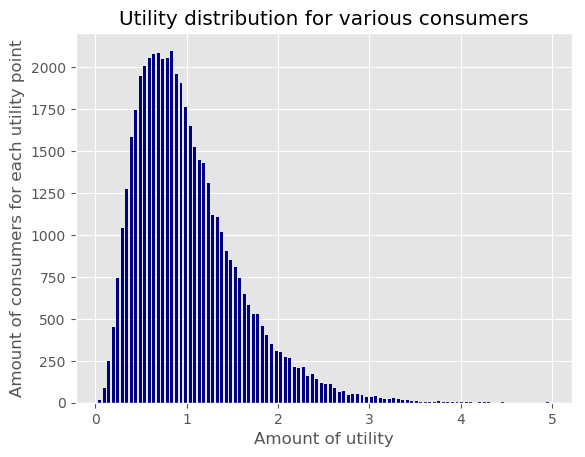

In [54]:
plt.style.use('ggplot')
plt.hist(uj_stars, bins = 100, rwidth = 0.65579, color = 'navy')
plt.title('Utility distribution for various consumers')
plt.xlabel('Amount of utility')
plt.ylabel('Amount of consumers for each utility point')
print("mean : "      , np.mean(uj_stars))
print("variance : "  , np.var(uj_stars))
print("skewness : "  , skew(uj_stars))
print("kurtosis : "  , kurtosis(uj_stars))

We see that skewness is 1.22 indicating a right-skewed figure which we observe by the longer right hand side tail.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

In [55]:
# Set new set of endowments, equal to mean of each initial endowment
e1 = np.zeros(N)+np.mean(e1)
e2 = np.zeros(N)+np.mean(e2)
e3 = np.zeros(N)+np.mean(e3)

# We define a new utility function for the evenly distributed endowments
uj_new = uj(betas, gamma, p1, p2, e1, e2, e3)

mean :  1.0463389325371582
variance :  0.0030203433723038817
skewness :  2.8922868419253893
kurtosis :  13.413249467536648


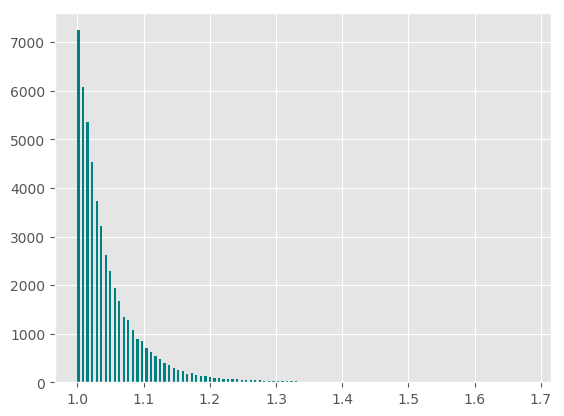

In [56]:
# We plot the new values in a histogram. 
plt.hist(uj_new, bins = 100, label = 'Evenly distributed endowments', color = 'teal', rwidth = 0.49579)
print("mean : "      , np.mean(uj_new))
print("variance : "  , np.var(uj_new))
print("skewness : "  , skew(uj_new))
print("kurtosis : "  , kurtosis(uj_new))

We see that skewness is 2.89 indicating a right-skewed figure which we observe by the longer right hand side tail. <br/>
We use the same functions as in **3.3** to reattempt the iteration from a different starting point.

We see a small increase in the mean utility and a substantial decrease in the variance by two orders of magnitude. This is due to no consumers having a utility less than $1$ and virtually no consumers having a utility higher than $1.35$. A utility level that was quite common when endowments were exponentially distributed.

In [59]:
# Defining the demand functions for each good
def good1_func(betas, p1, p2, e1, e2, e3):
    I = p1*e1 + p2*e2 + e3
    return betas[:,0]*I/p1

def good2_func(betas, p1, p2, e1, e2, e3):
    I = p1*e1 + p2*e2 + e3
    return betas[:,1]*I/p2

def good3_func(betas, p1, p2, e1, e2, e3):
    I = p1*e1 + p2*e2 + e3
    return betas[:,2]*I

# Defining the excess demand function for good 1
def excess1_func(betas, p1, p2, e1, e2, e3):
    
    # demand
    demand_1 = np.sum(good1_func(betas, p1, p2, e1, e2, e3))
    
    # supply
    supply_1 = np.sum(e1)
    
    # excess demand
    excess_demand_1 = demand_1 - supply_1
    
    return excess_demand_1

# Defining the excess demand function for good 2
def excess2_func(betas, p1, p2, e1, e2, e3):
    
    # demand
    demand_2 = np.sum(good2_func(betas, p1, p2, e1, e2, e3))
    
    # supply
    supply_2 = np.sum(e2)
    
    # excess demand
    excess_demand_2 = demand_2 - supply_2
    
    return excess_demand_2

# Defining the excess demand function for good 3
def excess3_func(betas, p1, p2, e1, e2, e3):
    
    # demand
    demand_3 = np.sum(demand_good_3_func(betas, p1, p2, e1, e2, e3))
    
    # supply
    supply_3 = np.sum(e3)
    
    # excess demand
    excess_demand_3 = demand_3 - supply_3
    
    return excess_demand_3

In [60]:
# Set parameters and initial prices
epsilon = 0.000001
kappa = 0.06
p1 = 6.490
p2 = 2.617

t=1
cap = 25000

# We minimize the values of our excess_func's from 3.2 until the excess demand is less than the threshold value epsilon
while t < cap:
    ex0_1 = excess1_func(betas, p1, p2, e1, e2, e3)
    ex0_2 = excess2_func(betas, p1, p2, e1, e2, e3)
    
    # If both values of ex0_1 are below the threshold value epsilon, break the loop
    if abs(ex0_1) < epsilon and abs(ex0_2) < epsilon:
        print(f'\nBy iterating {t} times, we find that the price of good 1 and 2 in Walras Equilibrium are: p1 = {p1: .3f} and p2 = {p2: .3f} when there exists no excess demand for good 3.')
        p1target = p1
        p2target = p2
        break
    
    # price developments according to the specified process 
    else:
        p1 += kappa*ex0_1/N
        p2 += kappa*ex0_2/N
    
    # Choice of which iterations to print
    if (t%5 == 0 and t<=50) or t%2500 == 0 or t == 500 or t == 13630 or t == 13631:
        print(f'Iteration {t} -> ex0_1:{ex0_1:5.4f} - ex0_2: {ex0_2:5.4f} -> p1: {p1:5.4f} - p2: {p2:5.4f}')
    
    # Let t move forward
    t += 1

Iteration 5 -> ex0_1:-11.5504 - ex0_2: 21.3941 -> p1: 6.4899 - p2: 2.6171
Iteration 10 -> ex0_1:-10.7585 - ex0_2: 19.3238 -> p1: 6.4899 - p2: 2.6173
Iteration 15 -> ex0_1:-10.0379 - ex0_2: 17.4448 -> p1: 6.4898 - p2: 2.6174
Iteration 20 -> ex0_1:-9.3822 - ex0_2: 15.7393 -> p1: 6.4897 - p2: 2.6175
Iteration 25 -> ex0_1:-8.7854 - ex0_2: 14.1915 -> p1: 6.4897 - p2: 2.6176
Iteration 30 -> ex0_1:-8.2420 - ex0_2: 12.7867 -> p1: 6.4896 - p2: 2.6176
Iteration 35 -> ex0_1:-7.7471 - ex0_2: 11.5118 -> p1: 6.4896 - p2: 2.6177
Iteration 40 -> ex0_1:-7.2964 - ex0_2: 10.3548 -> p1: 6.4895 - p2: 2.6178
Iteration 45 -> ex0_1:-6.8857 - ex0_2: 9.3049 -> p1: 6.4895 - p2: 2.6178
Iteration 50 -> ex0_1:-6.5113 - ex0_2: 8.3521 -> p1: 6.4895 - p2: 2.6179
Iteration 500 -> ex0_1:-1.8178 - ex0_2: -0.6772 -> p1: 6.4880 - p2: 2.6180
Iteration 2500 -> ex0_1:-0.2024 - ex0_2: -0.0756 -> p1: 6.4862 - p2: 2.6173
Iteration 5000 -> ex0_1:-0.0130 - ex0_2: -0.0049 -> p1: 6.4860 - p2: 2.6173
Iteration 7500 -> ex0_1:-0.0008 -

We see that the price of good 1 has fallen slightly from 6.490 to 6.486 and the price of good 2 has risen to an even lesser degree from 2.6167 to 2.6172. By changing the value of gamma we see no change in the amount of iterations nor the iterated price levels. <br/>